# Importing libs and database files 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import pingouin as pg
import seaborn as sns
from modules import analysis
from itertools import combinations
import scikit_posthocs as sp

# Importing Data

In [2]:
# importint a csv file.
project_dir = Path('')
df_gklab = pd.read_csv(
    project_dir / 'df_gklab_analysis_20250828.csv')

# Fix the type of the 'context' column
df_gklab['context'] = df_gklab['context'].astype(pd.Int64Dtype())
df_gklab['context'] = df_gklab['context'].astype(str)
df_gklab['context'] = df_gklab['context'].replace('0', '00')

# Exclude volunteers if needed

In [3]:
lst_excluded_volunteers = []

df_gklab = df_gklab[~df_gklab['ID_info'].isin(lst_excluded_volunteers)]

# Success Rate Analysis
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

         W   pval  normal
1.0  0.905  0.095    True
2.0  0.810  0.004   False
3.0  0.774  0.001   False
4.0  0.746  0.001   False
5.0  0.897  0.073    True
6.0  0.955  0.577    True


/home/victormoraes/Documents/GitHub/TMS-GoalkeeperGame/modules/analysis.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_rates = group.groupby('block_info').apply(
/home/victormoraes/Documents/GitHub/TMS-GoalkeeperGame/modules/analysis.py:125: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  success_rates = group.groupby('block_info').apply(
/home/victormoraes/Documents/GitHub/TMS-GoalkeeperGame/modules/ana

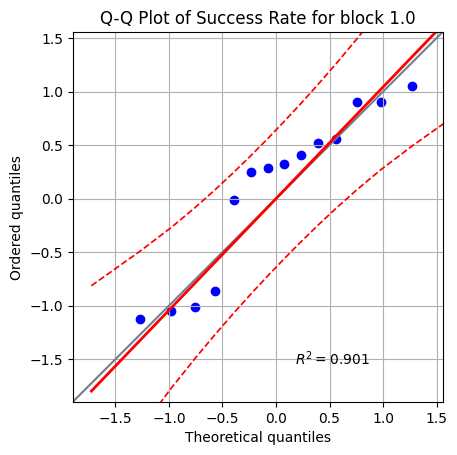

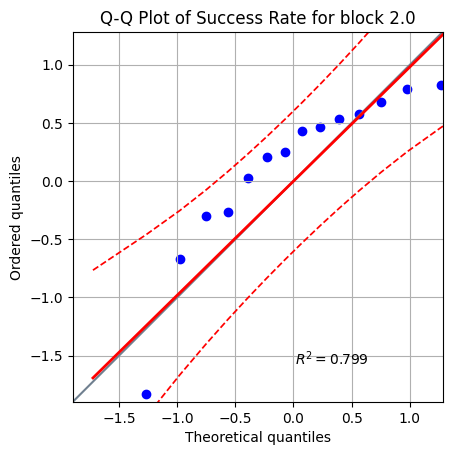

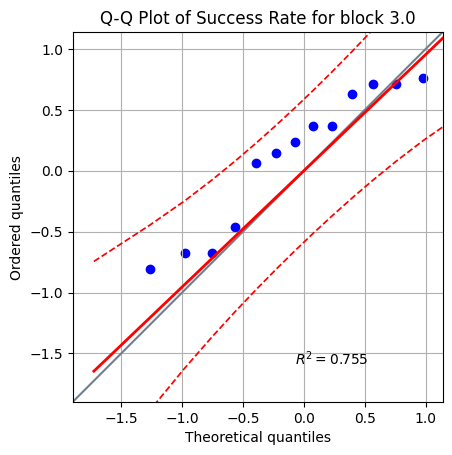

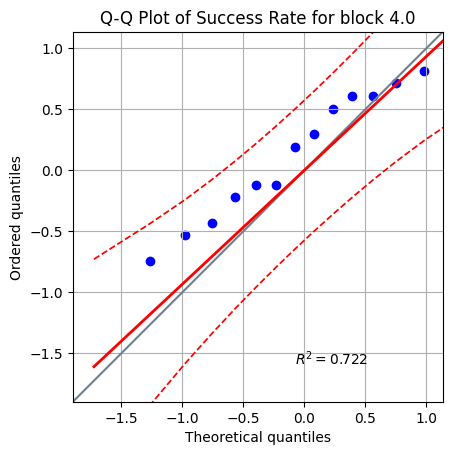

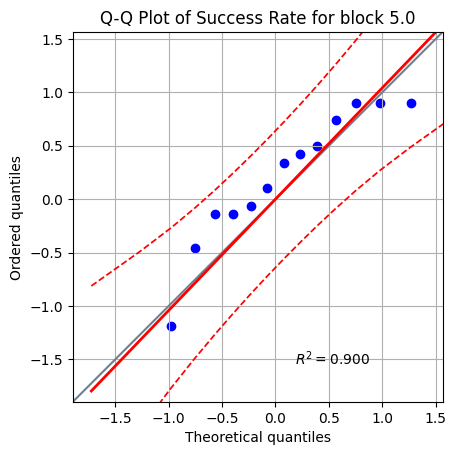

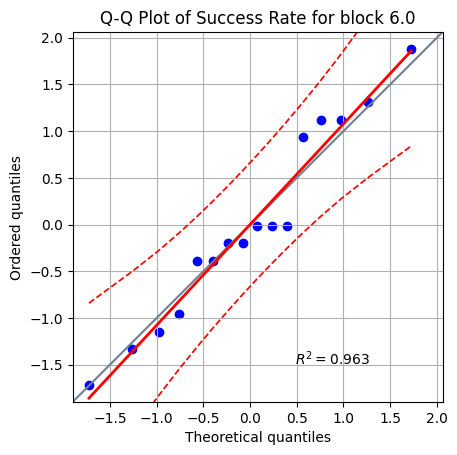

In [4]:
# Calculating mean values of subjects
success_rate_blocks = analysis.calculate_success_rate_by_block_group(df_gklab)

# Convert the dictionary to a DataFrame
success_rate_blocks_df = pd.DataFrame.from_dict(success_rate_blocks, orient='index')

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(success_rate_blocks_df)
print(shapiro_results.round(3))

# Q-Q plots for each block
for column in success_rate_blocks_df.columns:
    plt.figure()  # Create a new figure for each column
    pg.qqplot(success_rate_blocks_df[column], dist='norm')
    plt.title(f'Q-Q Plot of Success Rate for block {column}')
    plt.grid(True)
    plt.show()

# # Histograms for each block
# for column in success_rate_blocks_df.columns:
#     plt.figure()  # Create a new figure for each column
#     sns.histplot(success_rate_blocks_df[column], kde=True)
#     plt.title(f'Histogram of Success Rate for block {column}')
#     plt.xlabel('Success Rate')
#     plt.ylabel('Frequency')
#     plt.show()

In [5]:
# Convert wide format to long format
success_rate_blocks_df = success_rate_blocks_df.melt(var_name='Block', value_name='SuccessRate')

# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=success_rate_blocks_df, 
                          dv='SuccessRate', 
                          between='Block')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = success_rate_blocks_df['Block'].nunique()
n = len(success_rate_blocks_df)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(success_rate_blocks_df, val_col='SuccessRate', group_col='Block', p_adjust='fdr_bh') # Benjamini/Hochberg (non-negative) ‘fdr_bh’
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
        Source  ddof1       H  p-unc
Kruskal  Block      5  25.651    0.0

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.2295

Dunn's Post Hoc Test Results:
       1.0    2.0    3.0    4.0    5.0    6.0
1.0  1.000  0.057  0.036  0.002  0.000  0.000
2.0  0.057  1.000  0.807  0.327  0.172  0.095
3.0  0.036  0.807  1.000  0.441  0.249  0.143
4.0  0.002  0.327  0.441  1.000  0.746  0.498
5.0  0.000  0.172  0.249  0.746  1.000  0.746
6.0  0.000  0.095  0.143  0.498  0.746  1.000


# Response Time in different Buttons Analysis
- Normality and Homocedasticity Tests
- ANOVA one way

                   W   pval  normal
response_info                      
0.0            0.927  0.219    True
1.0            0.971  0.849    True
2.0            0.938  0.328    True


            W   pval  equal_var
levene  0.428  0.654       True


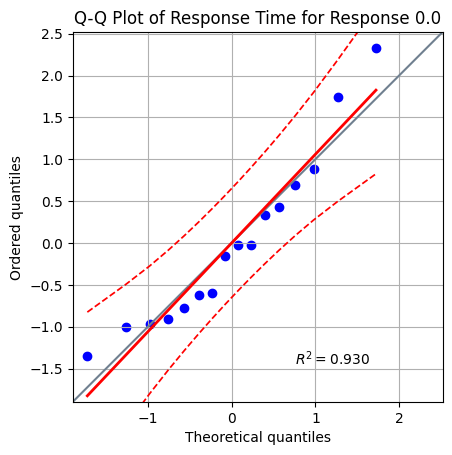

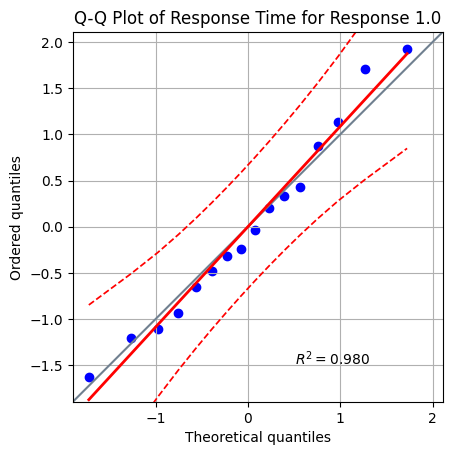

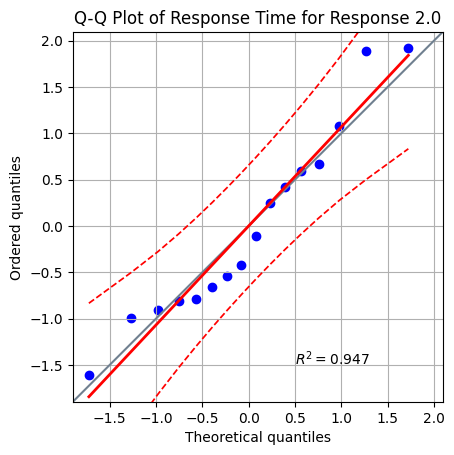

In [6]:
# Calculate mean response times grouped by ID_info and response_info and plot RTs by Responses
mean_response_times_by_responses = df_gklab.groupby(['ID_info', 'response_info'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_by_responses, dv='response_time_info', group='response_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_by_responses, dv='response_time_info', group='response_info')
print(levene_results.round(3))

# Q-Q plots for each response category
response_categories = mean_response_times_by_responses['response_info'].unique()
for response in response_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_by_responses[mean_response_times_by_responses['response_info'] == response]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for Response {response}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for response in response_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_by_responses[mean_response_times_by_responses['response_info'] == response]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for Response {response}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [7]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_by_responses, dv='response_time_info', between='response_info', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))

          Source     SS  DF     MS     F  p-unc    np2
0  response_info  0.046   2  0.023  2.18  0.125  0.088
1         Within  0.479  45  0.011   NaN    NaN    NaN


In [8]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_by_responses, 
                          dv='response_time_info', 
                          between='response_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_responses, val_col='response_time_info', group_col='response_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
                Source  ddof1      H  p-unc
Kruskal  response_info      2  3.751  0.153

No significant differences found; no post hoc analysis needed.


# Response Time by Blocks Analysis
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W   pval  normal
block_info                      
1.0         0.959  0.636    True
2.0         0.941  0.366    True
3.0         0.885  0.047   False
4.0         0.932  0.262    True
5.0         0.935  0.296    True
6.0         0.964  0.738    True


            W   pval  equal_var
levene  0.657  0.657       True


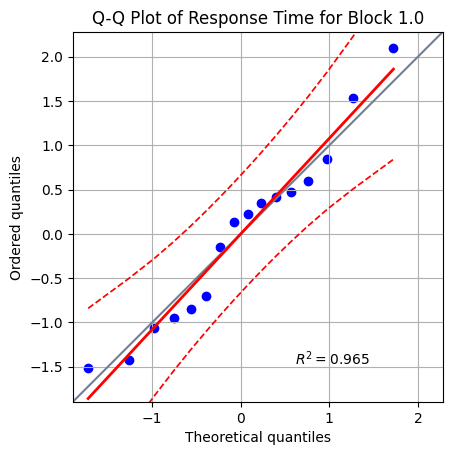

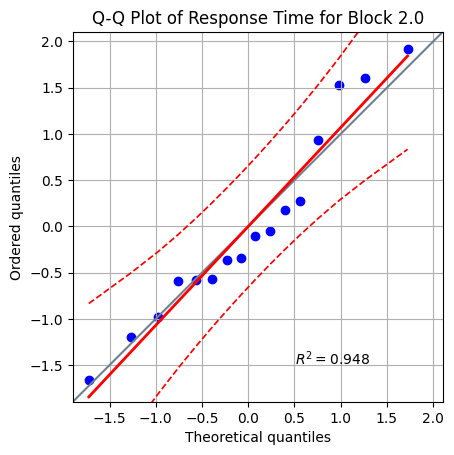

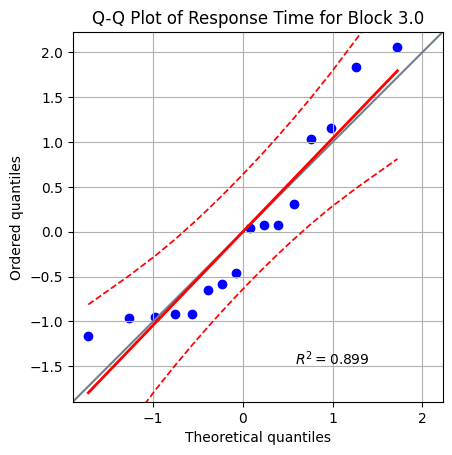

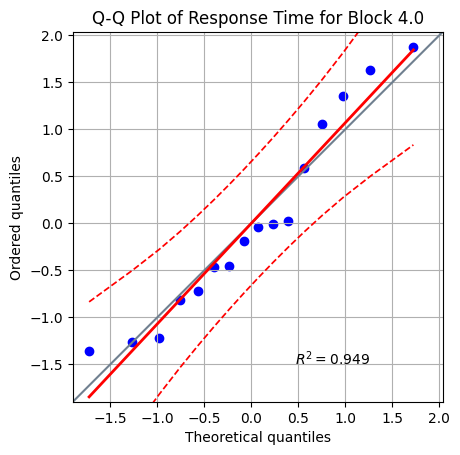

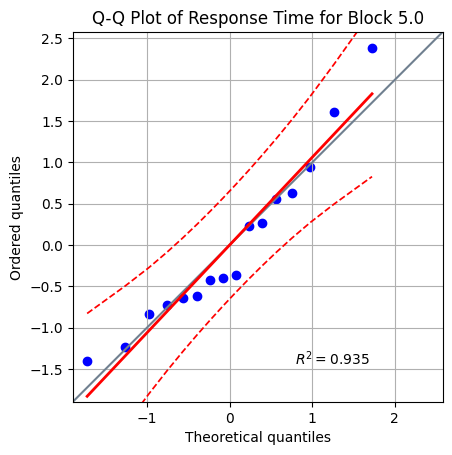

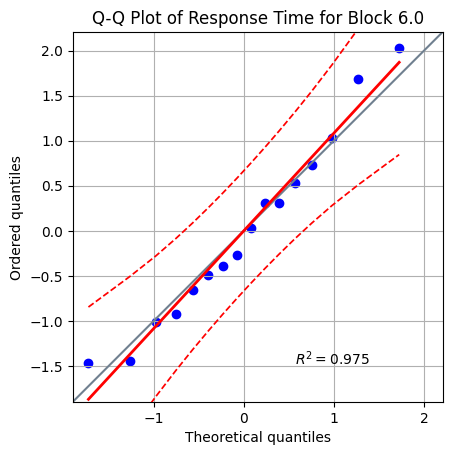

In [9]:
# Calculate mean response times grouped by ID_info and block_info and plot RTs by Blocks
mean_response_times_by_blocks = df_gklab.groupby(['ID_info', 'block_info'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_by_blocks, dv='response_time_info', group='block_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_by_blocks, dv='response_time_info', group='block_info')
print(levene_results.round(3))

# Q-Q plots for each response category
block_categories = mean_response_times_by_blocks['block_info'].unique()
for block in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_by_blocks[mean_response_times_by_blocks['block_info'] == block]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for Block {block}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for block in block_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_by_blocks[mean_response_times_by_blocks['block_info'] == block]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for Block {block}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [10]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_by_blocks, 
                          dv='response_time_info', 
                          between='block_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_by_blocks['block_info'].nunique()
n = len(mean_response_times_by_blocks)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_blocks, val_col='response_time_info', group_col='block_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
             Source  ddof1      H  p-unc
Kruskal  block_info      5  19.34  0.002

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.1593

Dunn's Post Hoc Test Results:
       1.0    2.0    3.0    4.0    5.0    6.0
1.0  1.000  0.380  0.087  0.010  0.081  0.002
2.0  0.380  1.000  0.387  0.099  0.380  0.033
3.0  0.087  0.387  1.000  0.387  0.909  0.201
4.0  0.010  0.099  0.387  1.000  0.424  0.546
5.0  0.081  0.380  0.909  0.424  1.000  0.222
6.0  0.002  0.033  0.201  0.546  0.222  1.000


# Response times with and without TMS pulses
- Normality test
- Unpaired T test

               W   pval  normal
tms_pulse                      
Pulse      0.947  0.443    True
noPulse    0.918  0.157    True


            W   pval  equal_var
levene  0.737  0.397       True


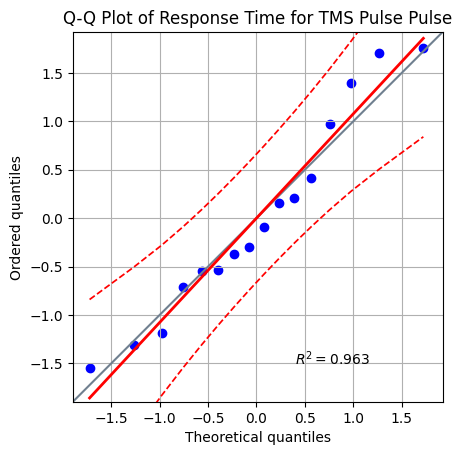

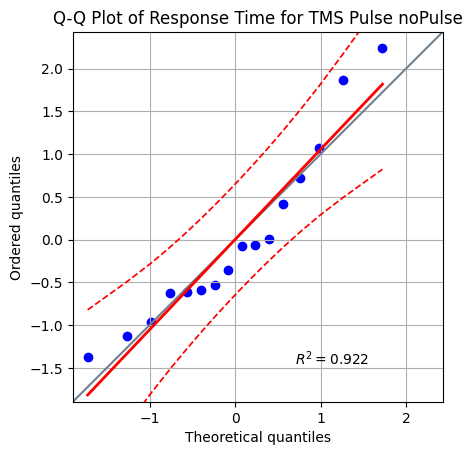

In [11]:
# Calculate mean response times grouped by ID_info and TMS pulse
mean_response_times_NoPulse_Pulse = df_gklab.groupby(['ID_info', 'tms_pulse'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_NoPulse_Pulse, dv='response_time_info', group='tms_pulse')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_NoPulse_Pulse, dv='response_time_info', group='tms_pulse')
print(levene_results.round(3))

# Q-Q plots for each response category
pulse_categories = mean_response_times_NoPulse_Pulse['tms_pulse'].unique()
for i in pulse_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for TMS Pulse {i}')
    plt.grid(True)
    plt.show()
    
# # Histograms for each response category
# for i in pulse_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for TMS Pulse {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [12]:
# Get x and y from dataframe
rt_with_tms = mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == 'Pulse']['response_time_info']
rt_without_tms = mean_response_times_NoPulse_Pulse[mean_response_times_NoPulse_Pulse['tms_pulse'] == 'noPulse']['response_time_info']

# Perform T test
ttest_results = pg.ttest(rt_with_tms, rt_without_tms, correction=False, paired=False)
print(ttest_results.round(3))

           T  dof alternative  p-val          CI95%  cohen-d   BF10  power
T-test -1.38   30   two-sided  0.178  [-0.13, 0.02]    0.488  0.691  0.267


# Response Time by Contexts during TMS pulses
- Normality test
- ANOVA with pairwise T tests and Benjamini/Hochberg correction

                W      pval  normal
context                            
00       0.960531  0.671440    True
1        0.953631  0.549302    True
10       0.922996  0.188461    True
2        0.946217  0.432226    True
20       0.956978  0.607456    True


               W      pval  equal_var
levene  0.239365  0.915207       True


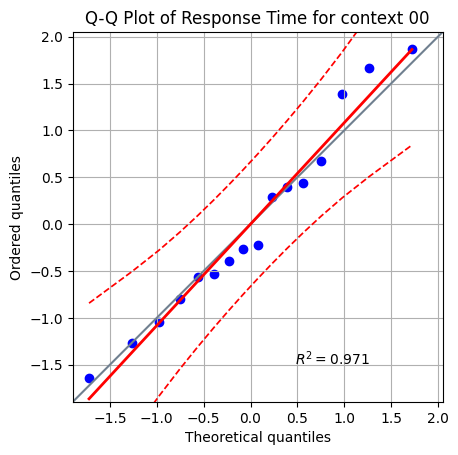

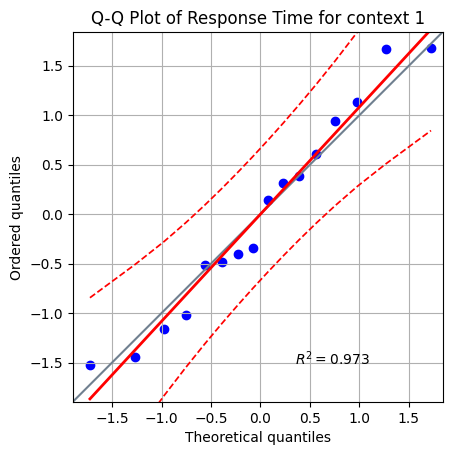

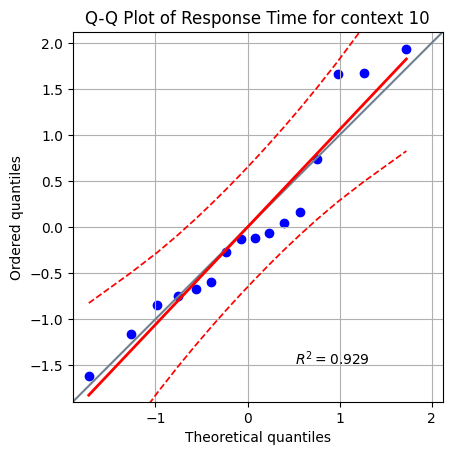

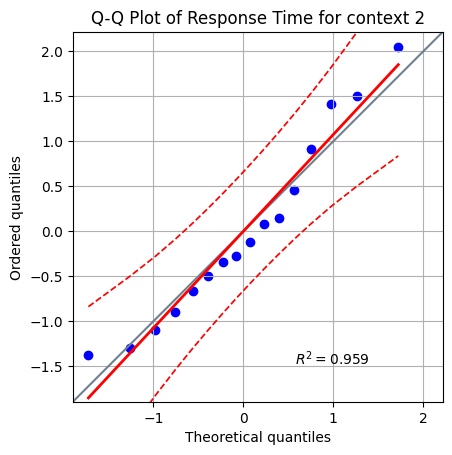

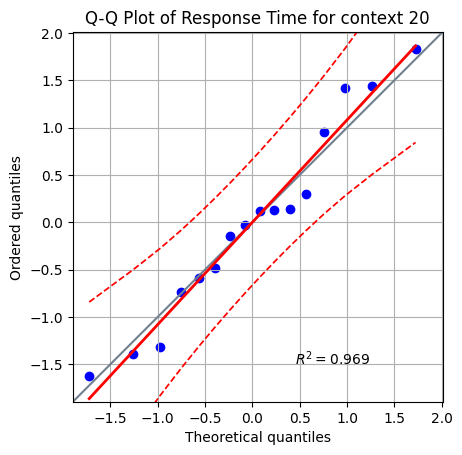

In [13]:
# Filter RTs during pulses
rt_pulse_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse') & (df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts and Plot   
mean_response_times_pulse_ctx = rt_pulse_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_pulse_ctx, dv='response_time_info', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_pulse_ctx, dv='response_time_info', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_response_times_pulse_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_pulse_ctx[mean_response_times_pulse_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_pulse_ctx[mean_response_times_pulse_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [14]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_pulse_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results)
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_pulse_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results)
    
else:
    print("No significant differences found; no post hoc analysis needed.")

    Source        SS  DF        MS         F     p-unc       np2
0  context  0.048339   4  0.012085  0.855013  0.495033  0.043612
1   Within  1.060043  75  0.014134       NaN       NaN       NaN


No significant differences found; no post hoc analysis needed.


In [15]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_pulse_ctx, 
                          dv='response_time_info', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_pulse_ctx['context'].nunique()
n = len(mean_response_times_pulse_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_pulse_ctx, val_col='response_time_info', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
          Source  ddof1      H  p-unc
Kruskal  context      4  3.552   0.47

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: -0.0060

No significant differences found; no post hoc analysis needed.


# Response Time by Contexts without TMS pulses
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W      pval  normal
context                            
00       0.926146  0.211681    True
1        0.932298  0.265044    True
10       0.939673  0.345029    True
2        0.903978  0.093090    True
20       0.916575  0.148558    True


               W      pval  equal_var
levene  0.383236  0.819969       True


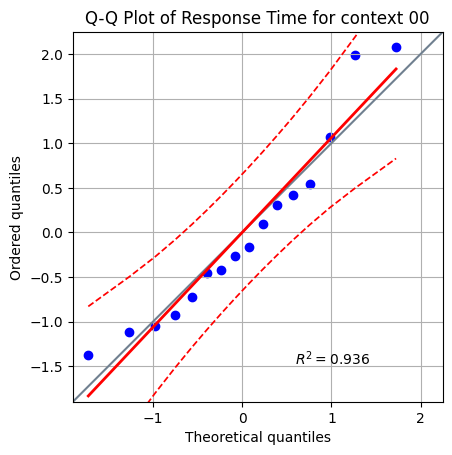

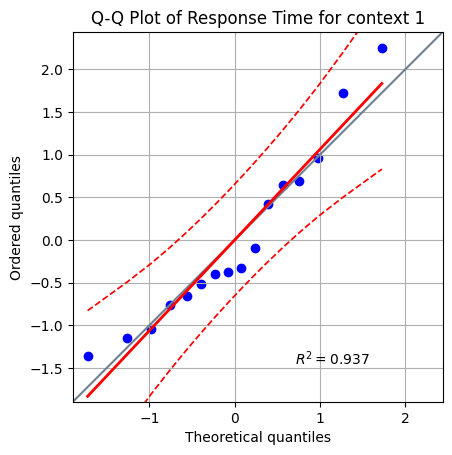

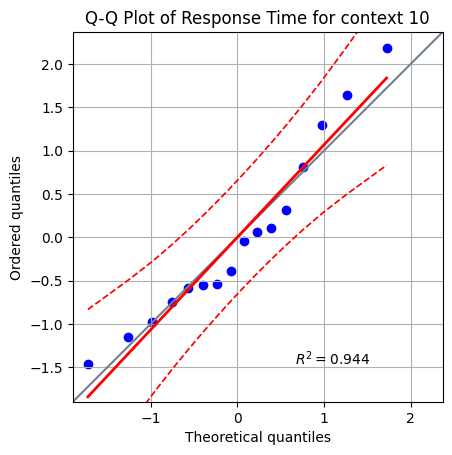

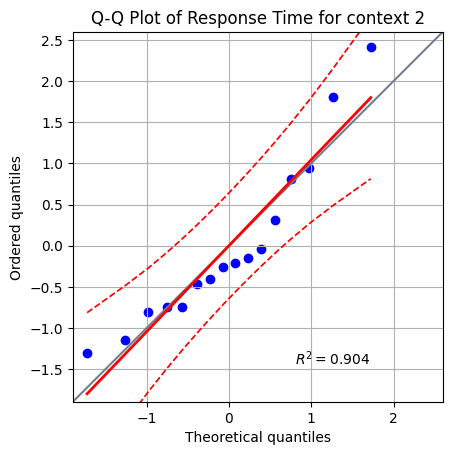

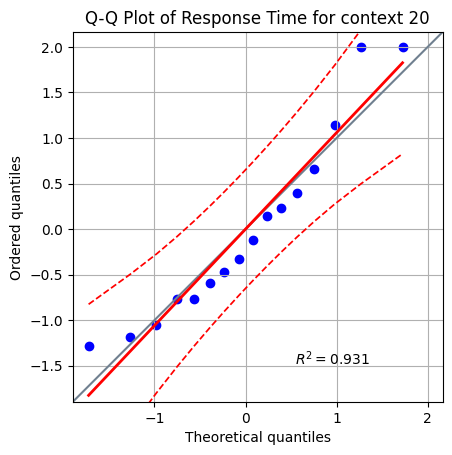

In [16]:
# Filter RTs during pulses
rt_nopulse_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'noPulse') & (df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts and Plot   
mean_response_times_nopulse_ctx = rt_nopulse_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_nopulse_ctx, dv='response_time_info', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_nopulse_ctx, dv='response_time_info', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_response_times_nopulse_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_nopulse_ctx[mean_response_times_nopulse_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_nopulse_ctx[mean_response_times_nopulse_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [17]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_nopulse_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results)
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_nopulse_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results)
    
else:
    print("No significant differences found; no post hoc analysis needed.")

    Source        SS  DF        MS         F   p-unc       np2
0  context  0.091865   4  0.022966  2.616491  0.0417  0.122458
1   Within  0.658313  75  0.008778       NaN     NaN       NaN


  Contrast   A   B  Paired  Parametric         T   dof alternative     p-unc  \
0  context  00   1   False        True -2.444843  30.0   two-sided  0.020580   
1  context  00  10   False        True -0.404946  30.0   two-sided  0.688390   
2  context  00   2   False        True -0.463621  30.0   two-sided  0.646265   
3  context  00  20   False        True  0.638904  30.0   two-sided  0.527734   
4  context   1  10   False        True  2.030324  30.0   two-sided  0.051271   
5  context   1   2   False        True  1.712837  30.0   two-sided  0.097061   
6  context   1  20   False        True  2.932690  30.0   two-sided  0.006380   
7  context  10   2   False        True -0.113094  30.0   two-sided  0.910709   
8  context  10  20   False        True  1.006925  30.0   two-sided  0.322024   
9  contex

In [18]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_response_times_nopulse_ctx, 
                          dv='response_time_info', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_response_times_nopulse_ctx['context'].nunique()
n = len(mean_response_times_nopulse_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_nopulse_ctx, val_col='response_time_info', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results.round(3))
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
          Source  ddof1      H  p-unc
Kruskal  context      4  9.489   0.05

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.0732

Dunn's Post Hoc Test Results:
       00      1     10      2     20
00  1.000  0.129  0.891  0.891  0.705
1   0.129  1.000  0.136  0.131  0.036
10  0.891  0.136  1.000  0.891  0.645
2   0.891  0.131  0.891  1.000  0.657
20  0.705  0.036  0.645  0.657  1.000


# Response Time by Contexts with all RTs (n=1200)
- Normality test
- ANOVA with pairwise T test and Benjamini/Hochberg correction

             W   pval  normal
context                      
00       0.931  0.251    True
1        0.942  0.376    True
10       0.905  0.096    True
2        0.940  0.344    True
20       0.958  0.634    True


            W   pval  equal_var
levene  0.395  0.811       True


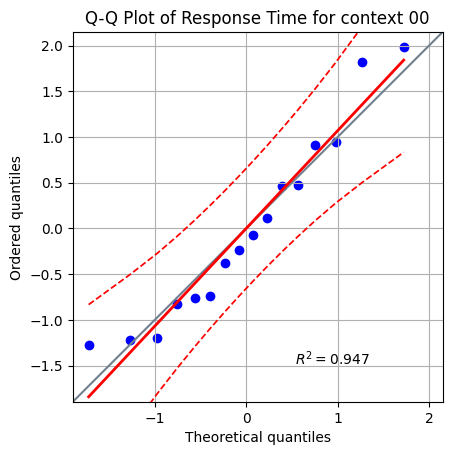

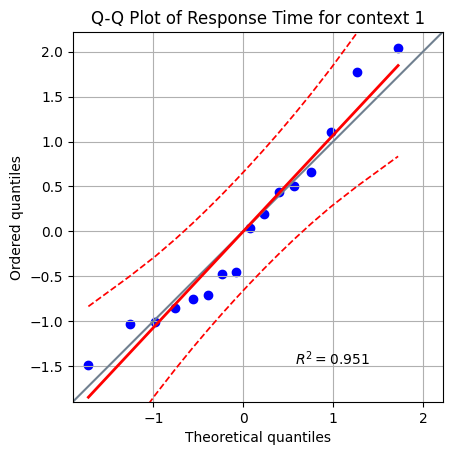

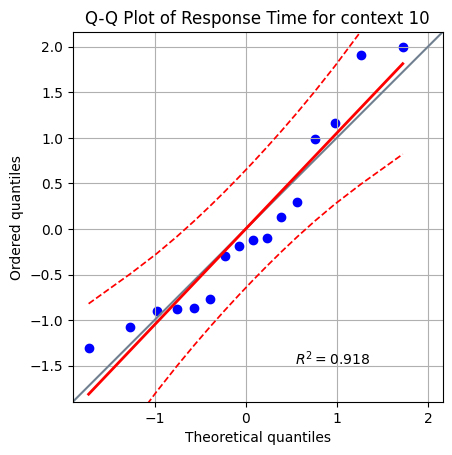

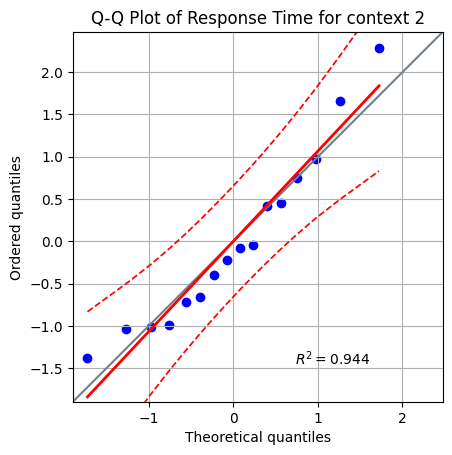

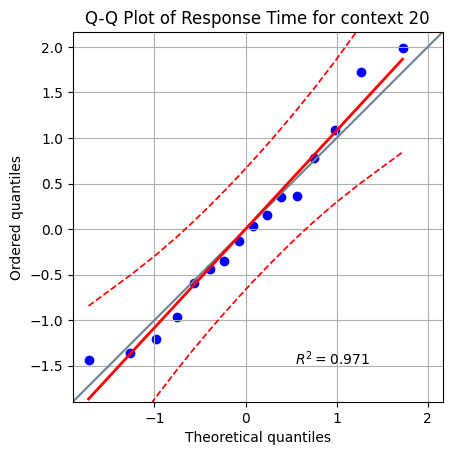

In [19]:
# Filter RTs
rt_df = df_gklab.loc[(df_gklab['context'] != '<NA>')]

# Get Mean Response Times by Contexts
mean_response_times_ctx = rt_df.groupby(['ID_info', 'context'])['response_time_info'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_response_times_ctx, dv='response_time_info', group='context')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_response_times_ctx, dv='response_time_info', group='context')
print(levene_results.round(3))

# Q-Q plots for each response category
ctx_categories = mean_response_times_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_response_times_ctx[mean_response_times_ctx['context'] == i]['response_time_info'], dist='norm')
    plt.title(f'Q-Q Plot of Response Time for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_response_times_ctx[mean_response_times_ctx['context'] == i]['response_time_info'], kde=True)
#     plt.title(f'Histogram of Response Time for context {i}')
#     plt.xlabel('Response Time')
#     plt.ylabel('Frequency')
#     plt.show()

In [20]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_response_times_ctx, dv='response_time_info', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Run post hoc tests if ANOVA is significant
if anova_results['p-unc'].values[0] < 0.05:
    posthoc_results = pg.pairwise_tests(data=mean_response_times_ctx, 
                                         dv='response_time_info', 
                                         between='context', 
                                         padjust='fdr_bh')
    print(posthoc_results.round(3))
    
else:
    print("No significant differences found; no post hoc analysis needed.")

    Source     SS  DF     MS      F  p-unc    np2
0  context  0.067   4  0.017  1.646  0.172  0.081
1   Within  0.766  75  0.010    NaN    NaN    NaN


No significant differences found; no post hoc analysis needed.


# Diference between error and success by Contexts during TMS pulse Analysis
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction or T-Test with Benjamini/Hochberg Correction

                W      pval  normal
context                            
00       0.966061  0.771472    True
1        0.911285  0.122056    True
10       0.945539  0.422462    True
2        0.978027  0.946002    True
20       0.977650  0.942195    True


               W      pval  equal_var
levene  5.488771  0.000625      False


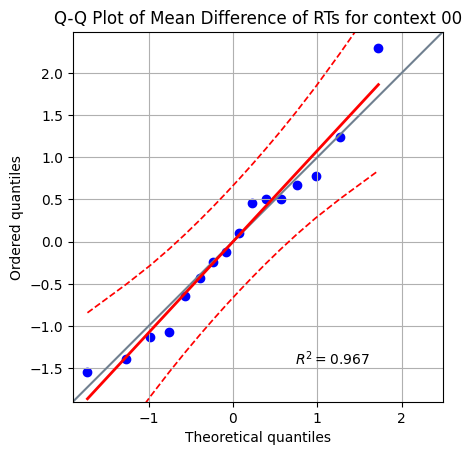

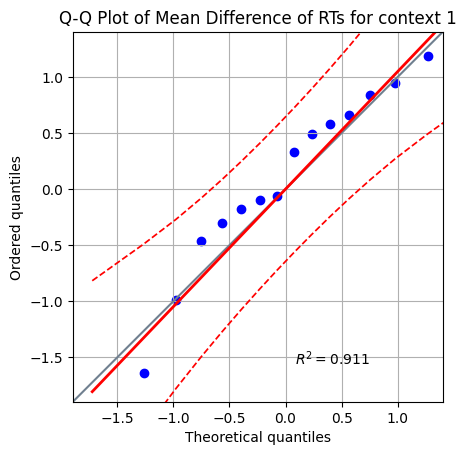

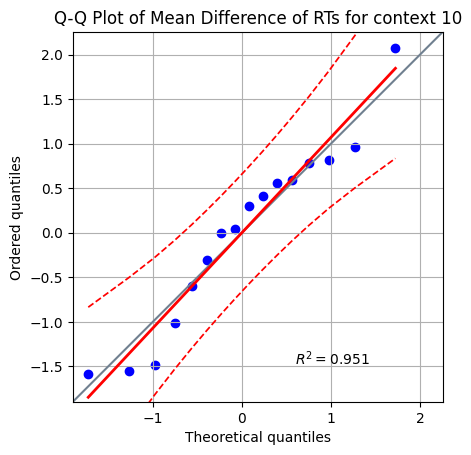

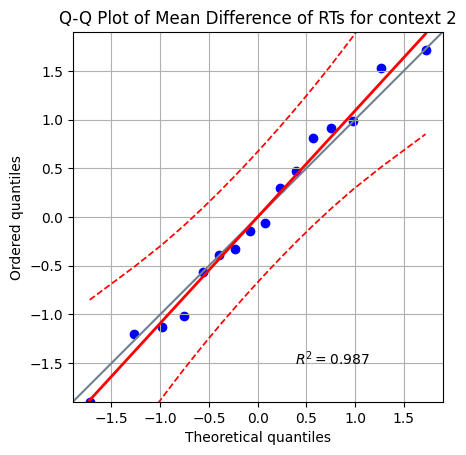

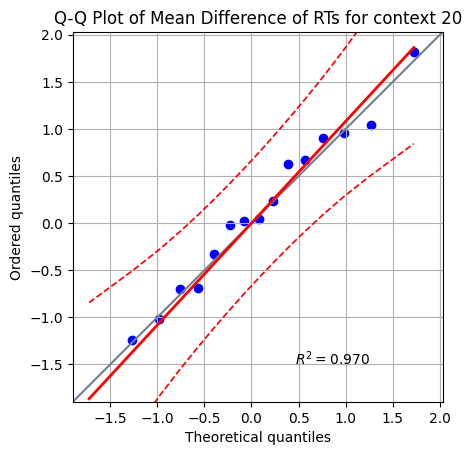

In [21]:
# Get Mean Response Times by Contexts and Plot   
mean_response_times_ctx_prevresult = rt_pulse_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()


In [22]:
### Using Wilcoxon signed rank test with Benjamini-Hochberg correction

from statsmodels.stats.multitest import multipletests

# Assuming stacked_df is your DataFrame
results_list = []
p_values = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    results = pg.wilcoxon(context_data['mean_difference'], context_data['reference'])
    
    # Collect p-value for Benjamini-Hochberg correction
    p_values.append(results['p-val'].iloc[0])
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'W': results['W-val'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'alternative': results['alternative'].iloc[0],
        'RBC': results['RBC'].iloc[0],
        'CLES': results['CLES'].iloc[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini-Hochberg correction
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = adjusted_p_values

results_df.round(3)

,context,W,p-val,alternative,RBC,CLES,adjusted_p-val
0,00,26.0,0.029,two-sided,-0.618,0.250,0.145
1,1,66.0,0.940,two-sided,-0.029,0.500,0.940
2,10,58.0,0.632,two-sided,-0.147,0.500,0.940
3,2,64.0,0.860,two-sided,0.059,0.500,0.940
4,20,38.0,0.130,two-sided,0.441,0.688,0.324


In [23]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)


,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,-2.350,0.033,0.831,0.165,False
1,1,-0.585,0.567,0.207,0.709,False
2,10,-0.827,0.421,0.292,0.702,False
3,2,0.352,0.730,0.124,0.730,False
4,20,1.380,0.188,0.488,0.470,False


# Diference between error and success by Contexts without TMS pulse Analysis
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction

                W      pval  normal
context                            
00       0.945296  0.418998    True
1        0.924376  0.198314    True
10       0.985734  0.993153    True
2        0.956701  0.602553    True
20       0.901472  0.084854    True


               W      pval  equal_var
levene  1.438306  0.229703       True


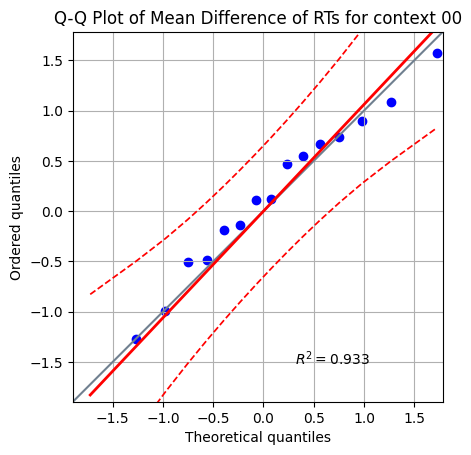

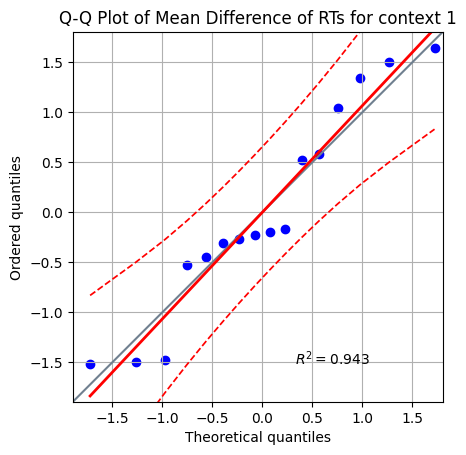

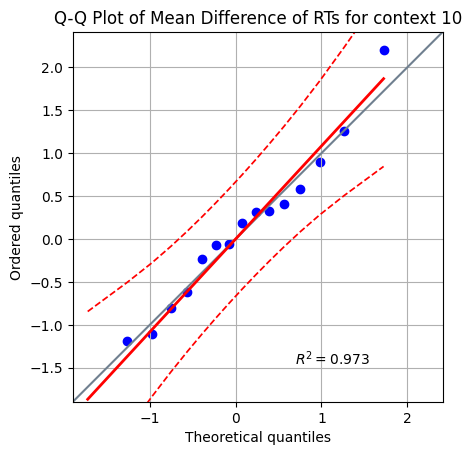

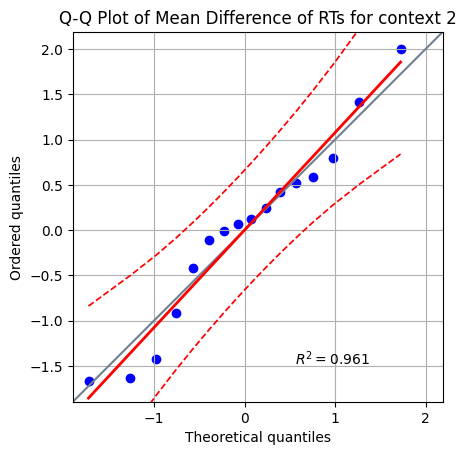

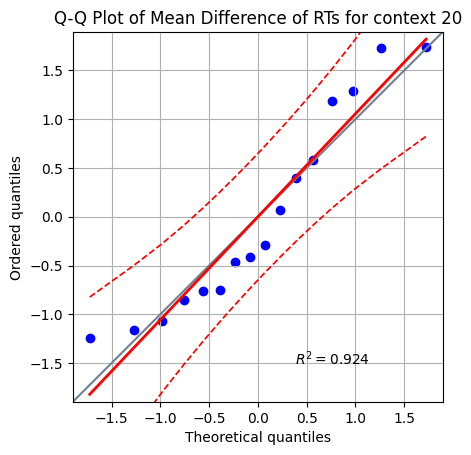

In [24]:
# Get Mean Response Times by Contexts and Plot   
mean_response_times_ctx_prevresult = rt_nopulse_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()


In [25]:
### Using Wilcoxon signed rank test with Benjamini-Hochberg correction

from statsmodels.stats.multitest import multipletests

# Assuming stacked_df is your DataFrame
results_list = []
p_values = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    results = pg.wilcoxon(context_data['mean_difference'], context_data['reference'])
    
    # Collect p-value for Benjamini-Hochberg correction
    p_values.append(results['p-val'].iloc[0])
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'W': results['W-val'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'alternative': results['alternative'].iloc[0],
        'RBC': results['RBC'].iloc[0],
        'CLES': results['CLES'].iloc[0]
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini-Hochberg correction
_, adjusted_p_values, _, _ = multipletests(p_values, method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = adjusted_p_values

results_df.round(3)

,context,W,p-val,alternative,RBC,CLES,adjusted_p-val
0,00,45.0,0.252,two-sided,-0.338,0.438,0.631
1,1,64.0,0.860,two-sided,0.059,0.375,0.900
2,10,35.0,0.093,two-sided,-0.485,0.250,0.467
3,2,65.0,0.900,two-sided,0.044,0.562,0.900
4,20,54.0,0.495,two-sided,0.206,0.500,0.826


In [26]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)

,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,-1.373,0.190,0.485,0.430,False
1,1,0.463,0.650,0.164,0.812,False
2,10,-1.653,0.119,0.584,0.430,False
3,2,-0.105,0.918,0.037,0.918,False
4,20,1.176,0.258,0.416,0.430,False


# Diference between error and success by Contexts with all RTs (n = 1200)
- Normality test
- ANOVA

                W      pval  normal
context                            
00       0.960072  0.663105    True
1        0.975576  0.918824    True
10       0.872442  0.029644   False
2        0.966213  0.774169    True
20       0.964452  0.742718    True


               W      pval  equal_var
levene  2.227643  0.073976       True


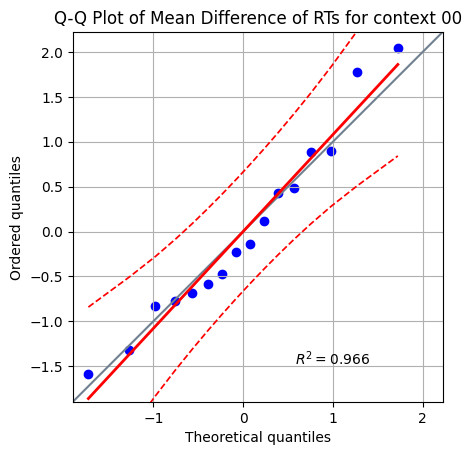

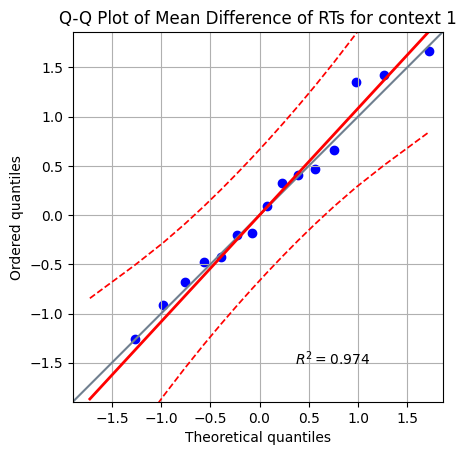

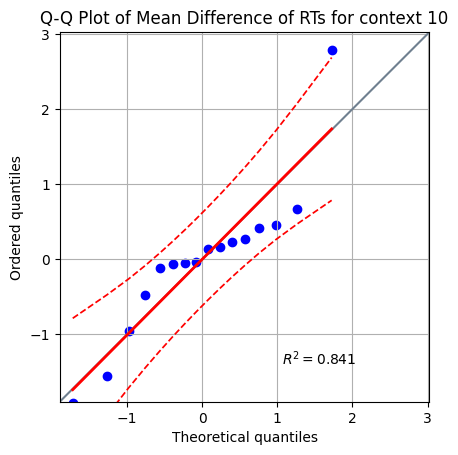

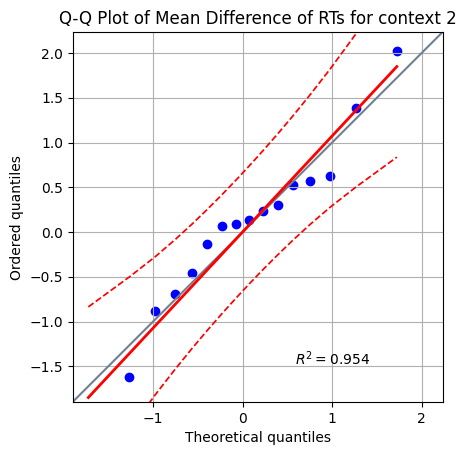

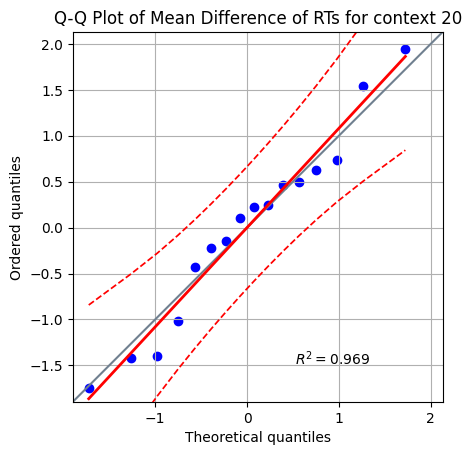

In [27]:
# Get Mean Response Times by Contexts and Plot   
mean_all_response_times_ctx_prevresult = rt_df.groupby(['ID_info', 'context', 'last_was_error'])['response_time_info'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_all_response_times_ctx_prevresult,
                            values='response_time_info',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of Mean Difference of RTs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of Response Times Mean Difference for context {i}')
#     plt.xlabel('Response Time Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()

In [28]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df.round(3)

,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,-2.181,0.046,0.771,0.114,False
1,1,0.243,0.811,0.086,0.811,False
2,10,-1.254,0.229,0.443,0.382,False
3,2,0.399,0.695,0.141,0.811,False
4,20,2.491,0.025,0.881,0.114,False


# MEP differences between blocks
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W  pval  normal
block_info                     
2.0         0.945  0.41    True
4.0         0.945  0.42    True
6.0         0.725  0.00   False


           W   pval  equal_var
levene  0.09  0.914       True


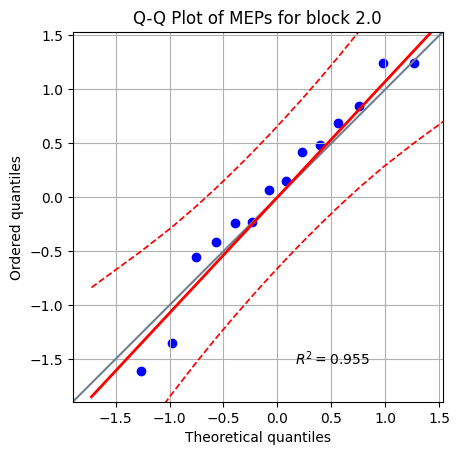

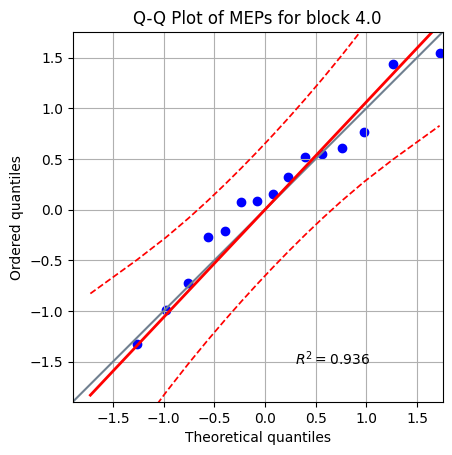

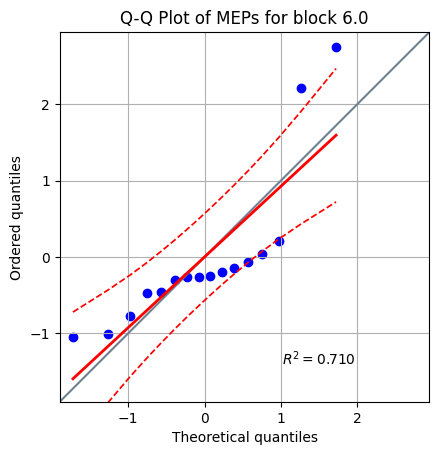

In [29]:
# Filter MEPs during pulses
meps_blocks_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse')]

# Calculate mean FDI MEPs grouped by ID_info and block_info
mean_FDImeps_by_blocks = meps_blocks_df.groupby(['ID_info', 'block_info'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_FDImeps_by_blocks, dv='relMean_MEPpp_FDI', group='block_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_FDImeps_by_blocks, dv='relMean_MEPpp_FDI', group='block_info')
print(levene_results.round(3))

# Q-Q plots for each MEP block
block_categories = mean_FDImeps_by_blocks['block_info'].unique()
for i in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_FDImeps_by_blocks[mean_FDImeps_by_blocks['block_info'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of MEPs for block {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in block_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_FDImeps_by_blocks[mean_FDImeps_by_blocks['block_info'] == i]['relMean_MEPpp_FDI'], kde=True)
#     plt.title(f'Histogram of FDI MEPs for block {i}')
#     plt.xlabel('FDI MEPs')
#     plt.ylabel('Frequency')
#     plt.show()

In [30]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_FDImeps_by_blocks, 
                          dv='relMean_MEPpp_FDI', 
                          between='block_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_FDImeps_by_blocks['block_info'].nunique()
n = len(mean_FDImeps_by_blocks)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_response_times_by_blocks, val_col='relMean_MEPpp_FDI', group_col='block_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
             Source  ddof1      H  p-unc
Kruskal  block_info      2  0.622  0.733

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: -0.0306

No significant differences found; no post hoc analysis needed.


# FDI MEP difference between responses

                   W   pval  normal
response_info                      
0.0            0.879  0.038   False
1.0            0.953  0.547    True
2.0            0.911  0.119    True


            W  pval  equal_var
levene  1.431  0.25       True


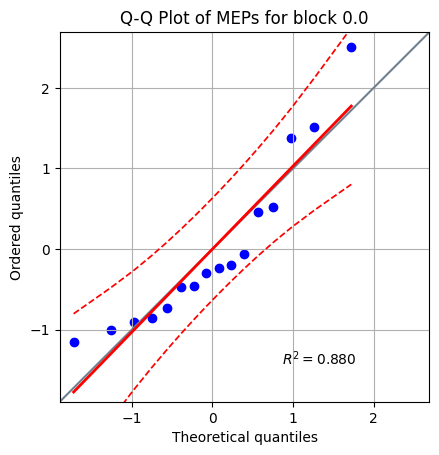

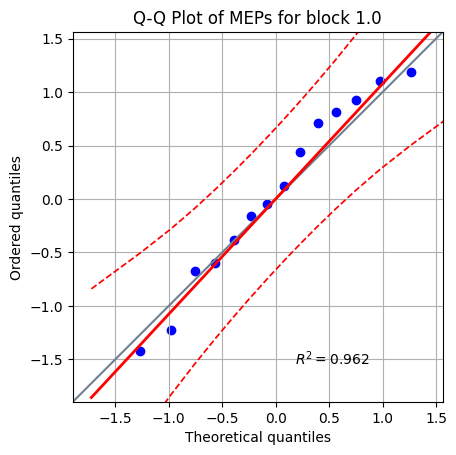

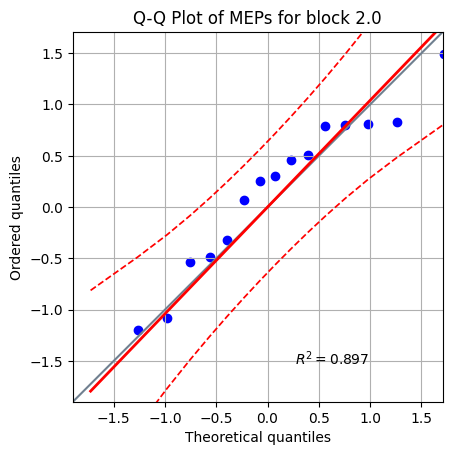

In [31]:
# Calculate mean FDI MEPs grouped by ID_info and response_info
mean_FDImeps_by_response = meps_blocks_df.groupby(['ID_info', 'response_info'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_FDImeps_by_response, dv='relMean_MEPpp_FDI', group='response_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_FDImeps_by_response, dv='relMean_MEPpp_FDI', group='response_info')
print(levene_results.round(3))

# Q-Q plots for each MEP block
block_categories = mean_FDImeps_by_response['response_info'].unique()
for i in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_FDImeps_by_response[mean_FDImeps_by_response['response_info'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of MEPs for block {i}')
    plt.grid(True)
    plt.show()

In [32]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_FDImeps_by_response, 
                          dv='relMean_MEPpp_FDI', 
                          between='response_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_FDImeps_by_response['response_info'].nunique()
n = len(mean_FDImeps_by_response)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_FDImeps_by_response, val_col='relMean_MEPpp_FDI', group_col='response_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
                Source  ddof1       H  p-unc
Kruskal  response_info      2  13.156  0.001

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.2479

Dunn's Post Hoc Test Results:
          0.0       1.0       2.0
0.0  1.000000  0.001866  0.008867
1.0  0.001866  1.000000  0.503351
2.0  0.008867  0.503351  1.000000


# FDI MEP differences by contexts
- Normality test
- Kruskal-Wallis test and Dunn's post hoc with Benjamini/Hochberg correction 

                W      pval  normal
context                            
00       0.965572  0.762799    True
1        0.846008  0.011907   False
10       0.935938  0.302195    True
2        0.916644  0.148937    True
20       0.930283  0.246318    True


               W      pval  equal_var
levene  2.318499  0.064733       True


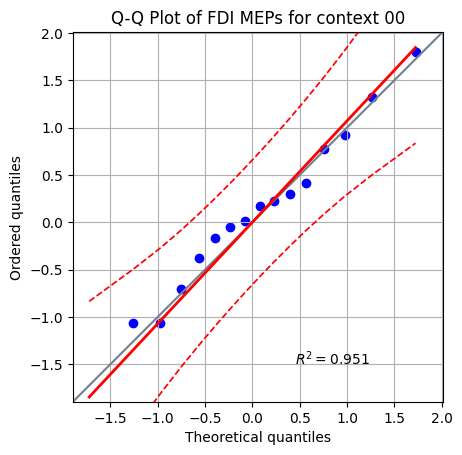

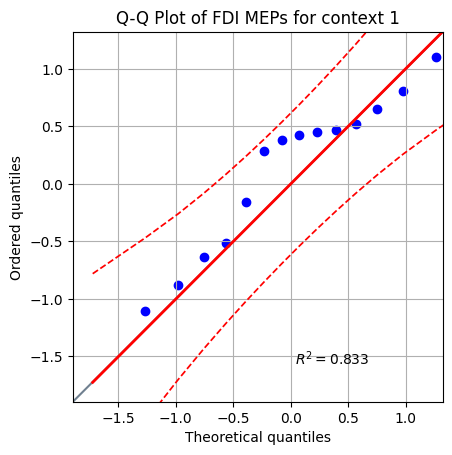

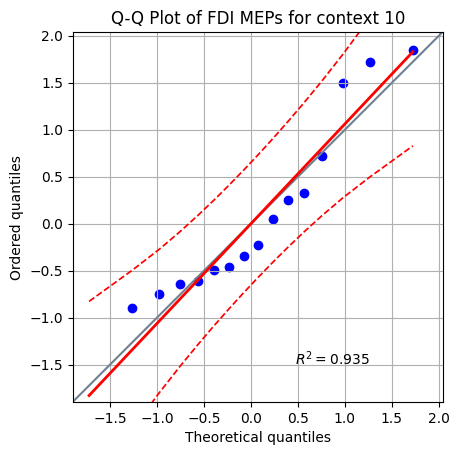

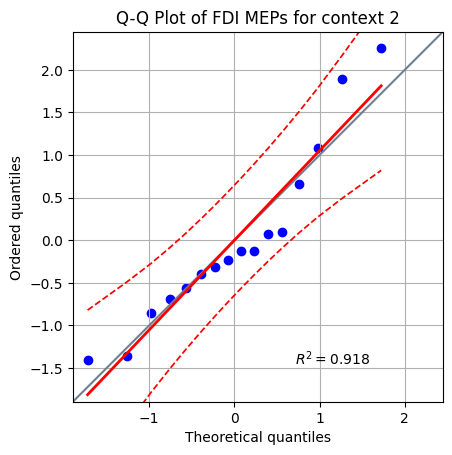

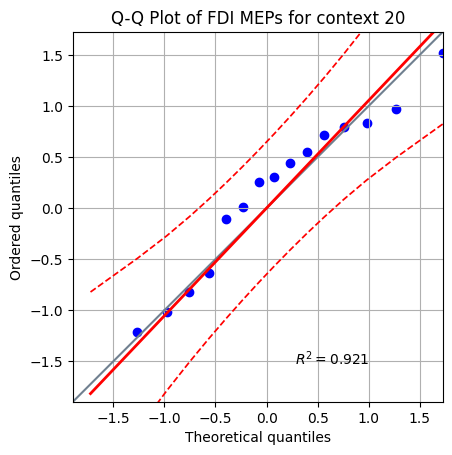

In [33]:
# Filter MEPs during pulses
meps_blocks_df = df_gklab.loc[(df_gklab['tms_pulse'] == 'Pulse') & (df_gklab['context'] != '<NA>')]

# Get Mean FDI MEPs relative to mean by Contexts    
mean_relmFDImepsmean_ctx = meps_blocks_df.groupby(['ID_info', 'context'])['relMean_MEPpp_FDI'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_relmFDImepsmean_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_relmFDImepsmean_ctx[mean_relmFDImepsmean_ctx['context'] == i]['relMean_MEPpp_FDI'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(mean_relmFDImepsmean_ctx[mean_relmFDImepsmean_ctx['context'] == i]['relMean_MEPpp_FDI'], kde=True)
#     plt.title(f'Histogram of FDI MEPs for context {i}')
#     plt.xlabel('FDI MEPs')
#     plt.ylabel('Frequency')
#     plt.show()

In [34]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_relmFDImepsmean_ctx, dv='relMean_MEPpp_FDI', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Perform post hoc tests with Benjamini/Hochberg correction
posthoc_results = pg.pairwise_tests(data=mean_relmFDImepsmean_ctx, 
                                     dv='relMean_MEPpp_FDI', 
                                     between='context', 
                                     padjust='fdr_bh')

# Print the post hoc results
print(posthoc_results.round(3))

    Source     SS  DF     MS      F  p-unc    np2
0  context  0.074   4  0.019  4.094  0.005  0.179
1   Within  0.339  75  0.005    NaN    NaN    NaN


  Contrast   A   B  Paired  Parametric      T   dof alternative  p-unc  \
0  context  00   1   False        True -0.107  30.0   two-sided  0.915   
1  context  00  10   False        True -2.556  30.0   two-sided  0.016   
2  context  00   2   False        True -2.180  30.0   two-sided  0.037   
3  context  00  20   False        True -0.505  30.0   two-sided  0.617   
4  context   1  10   False        True -2.778  30.0   two-sided  0.009   
5  context   1   2   False        True -2.377  30.0   two-sided  0.024   
6  context   1  20   False        True -0.525  30.0   two-sided  0.604   
7  context  10   2   False        True  0.418  30.0   two-sided  0.679   
8  context  10  20   False        True  2.626  30.0   two-sided  0.013   
9  context   2  20   False        True  2.199  30.0   two-sided  0.036   

   p-corr p-adjust   BF10  hedges

In [35]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_relmFDImepsmean_ctx, 
                          dv='relMean_MEPpp_FDI', 
                          between='context')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_relmFDImepsmean_ctx['context'].nunique()
n = len(mean_relmFDImepsmean_ctx)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_relmFDImepsmean_ctx, val_col='relMean_MEPpp_FDI', group_col='context', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
          Source  ddof1       H  p-unc
Kruskal  context      4  12.171  0.016

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.1089

Dunn's Post Hoc Test Results:
          00         1        10         2        20
00  1.000000  0.921222  0.065697  0.082922  0.921222
1   0.921222  1.000000  0.065697  0.084482  0.921222
10  0.065697  0.065697  1.000000  0.921222  0.073446
2   0.082922  0.084482  0.921222  1.000000  0.109380
20  0.921222  0.921222  0.073446  0.109380  1.000000


# FDS MEP difference between responses

                   W   pval  normal
response_info                      
0.0            0.966  0.772    True
1.0            0.872  0.030   False
2.0            0.943  0.388    True


            W   pval  equal_var
levene  3.035  0.058       True


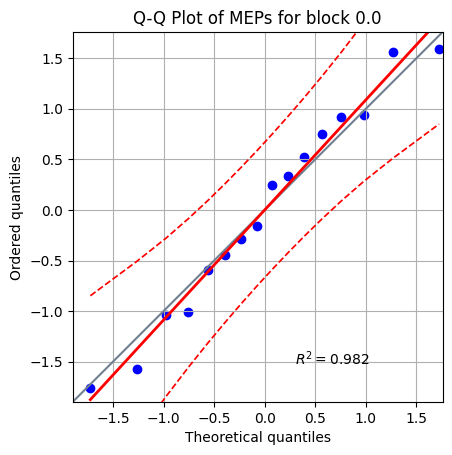

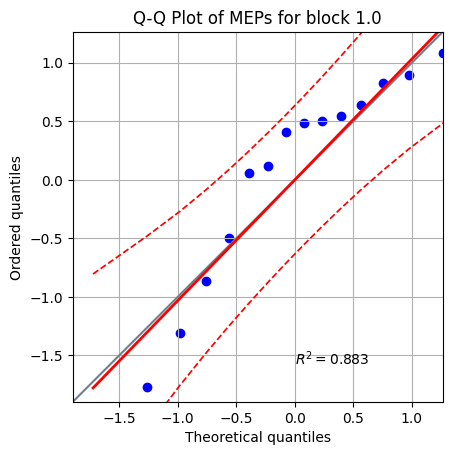

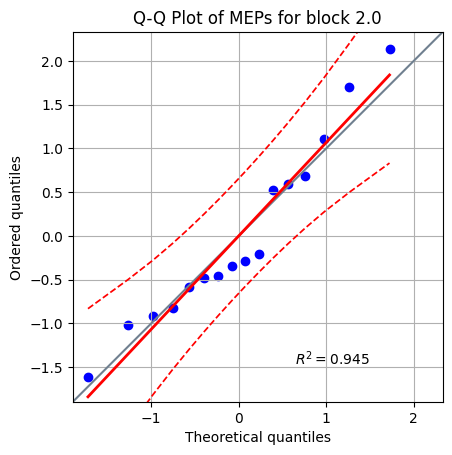

In [36]:
# Calculate mean FDS MEPs grouped by ID_info and response_info
mean_FDSmeps_by_response = meps_blocks_df.groupby(['ID_info', 'response_info'])['relMean_MEPpp_FDS'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_FDSmeps_by_response, dv='relMean_MEPpp_FDS', group='response_info')
print(shapiro_results.round(3))
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_FDSmeps_by_response, dv='relMean_MEPpp_FDS', group='response_info')
print(levene_results.round(3))

# Q-Q plots for each MEP block
block_categories = mean_FDSmeps_by_response['response_info'].unique()
for i in block_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_FDSmeps_by_response[mean_FDSmeps_by_response['response_info'] == i]['relMean_MEPpp_FDS'], dist='norm')
    plt.title(f'Q-Q Plot of MEPs for block {i}')
    plt.grid(True)
    plt.show()

In [37]:
# Perform Kruskal-Wallis test
kruskal_res = pg.kruskal(data=mean_FDSmeps_by_response, 
                          dv='relMean_MEPpp_FDS', 
                          between='response_info')

print("Kruskal-Wallis Test Results:")
print(kruskal_res.round(3))

# Extrair estatística H, número de grupos e total de observações e calcular η² adaptado
H = kruskal_res['H'].values[0]
k = mean_FDSmeps_by_response['response_info'].nunique()
n = len(mean_FDSmeps_by_response)

eta_sq = (H - k + 1) / (n - k)
print(f"\nEta ao quadrado adaptado (η²) para Kruskal-Wallis: {eta_sq:.4f}")

# Post Hoc Analysis if significant
if kruskal_res['p-unc'].values[0] < 0.05:  # Check if p-value is significant
    # Perform Dunn's post hoc test using scikit_posthocs
    dunn_results = sp.posthoc_dunn(mean_FDSmeps_by_response, val_col='relMean_MEPpp_FDS', group_col='response_info', p_adjust='fdr_bh')
    print("\nDunn's Post Hoc Test Results:")
    print(dunn_results)
else:
    print("\nNo significant differences found; no post hoc analysis needed.")

Kruskal-Wallis Test Results:
                Source  ddof1       H  p-unc
Kruskal  response_info      2  26.641    0.0

Eta ao quadrado adaptado (η²) para Kruskal-Wallis: 0.5476

Dunn's Post Hoc Test Results:
          0.0       1.0       2.0
0.0  1.000000  0.411789  0.000094
1.0  0.411789  1.000000  0.000004
2.0  0.000094  0.000004  1.000000


## Analysing FDS MEPs by context

                W      pval  normal
context                            
00       0.962686  0.710689    True
1        0.897096  0.072221    True
10       0.961942  0.697138    True
2        0.915234  0.141341    True
20       0.949357  0.479567    True


               W      pval  equal_var
levene  0.642948  0.633555       True


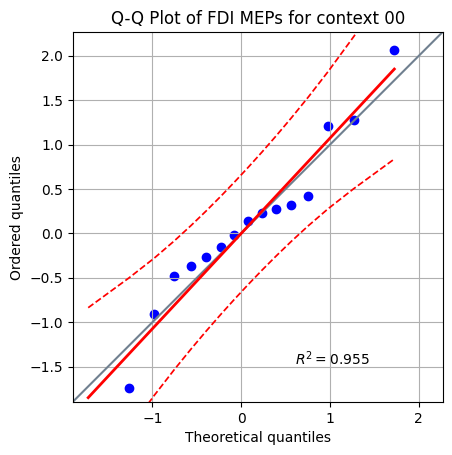

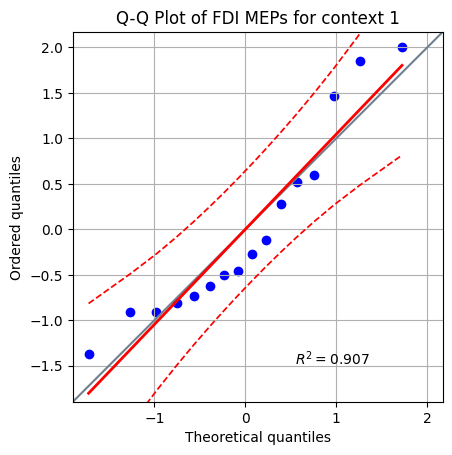

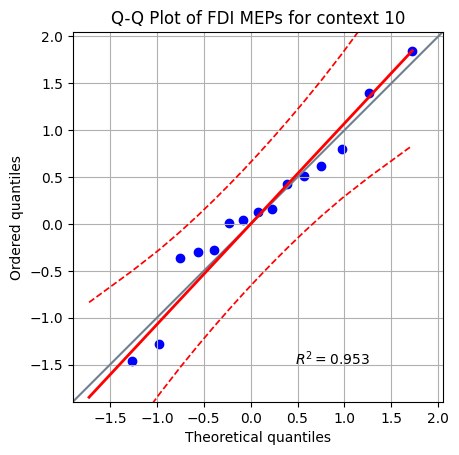

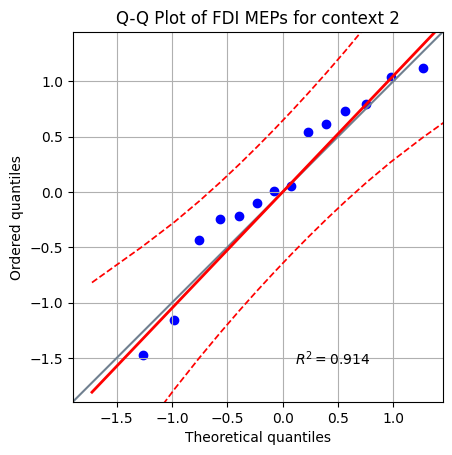

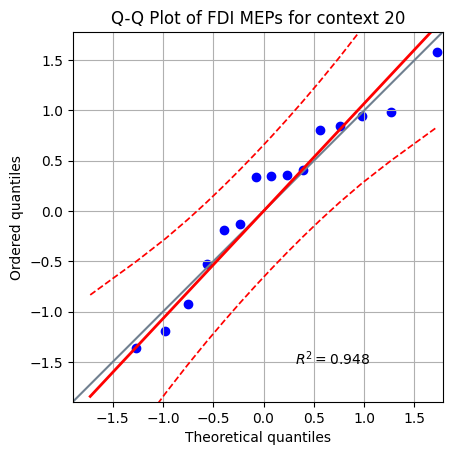

In [38]:
# Get Mean FDS MEPs relative to mean by Contexts    
mean_relmFDSmepsmean_ctx = meps_blocks_df.groupby(['ID_info', 'context'])['relMean_MEPpp_FDS'].mean().reset_index()

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = mean_relmFDSmepsmean_ctx['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(mean_relmFDSmepsmean_ctx[mean_relmFDSmepsmean_ctx['context'] == i]['relMean_MEPpp_FDS'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs for context {i}')
    plt.grid(True)
    plt.show()

In [39]:
# Perform one-way ANOVA
anova_results = pg.anova(data=mean_relmFDSmepsmean_ctx, dv='relMean_MEPpp_FDS', between='context', detailed=True)

# Print the ANOVA results
print(anova_results.round(3))
print("\n")

# Perform post hoc tests with Benjamini/Hochberg correction
posthoc_results = pg.pairwise_tests(data=mean_relmFDSmepsmean_ctx, 
                                     dv='relMean_MEPpp_FDS', 
                                     between='context', 
                                     padjust='fdr_bh')

# Print the post hoc results
print(posthoc_results.round(3))

    Source     SS  DF     MS       F  p-unc    np2
0  context  0.142   4  0.036  10.919    0.0  0.368
1   Within  0.244  75  0.003     NaN    NaN    NaN


  Contrast   A   B  Paired  Parametric      T   dof alternative  p-unc  \
0  context  00   1   False        True -4.872  30.0   two-sided  0.000   
1  context  00  10   False        True -0.406  30.0   two-sided  0.687   
2  context  00   2   False        True  0.320  30.0   two-sided  0.751   
3  context  00  20   False        True  1.427  30.0   two-sided  0.164   
4  context   1  10   False        True  3.863  30.0   two-sided  0.001   
5  context   1   2   False        True  4.953  30.0   two-sided  0.000   
6  context   1  20   False        True  5.444  30.0   two-sided  0.000   
7  context  10   2   False        True  0.653  30.0   two-sided  0.519   
8  context  10  20   False        True  1.573  30.0   two-sided  0.126   
9  context   2  20   False        True  1.107  30.0   two-sided  0.277   

   p-corr p-adjust     BF10  h

# MEP diference between error and success by Contexts
- Normality test
- Wilcoxon signed rank test with Benjamini-Hochberg correction or T-Test with Benjamini/Hochberg Correction

                W      pval  normal
context                            
00       0.948077  0.459846    True
1        0.962929  0.715118    True
10       0.964678  0.746787    True
2        0.956267  0.594885    True
20       0.984000  0.987369    True


               W      pval  equal_var
levene  4.953967  0.001343      False


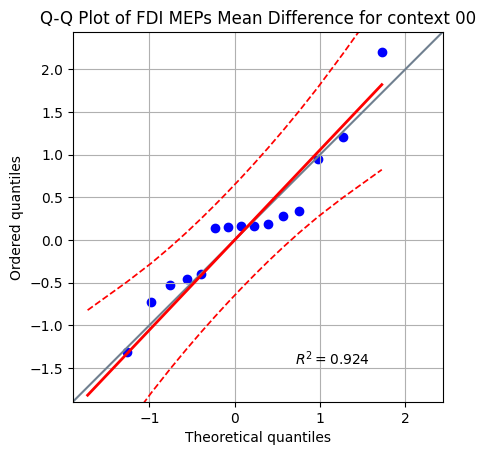

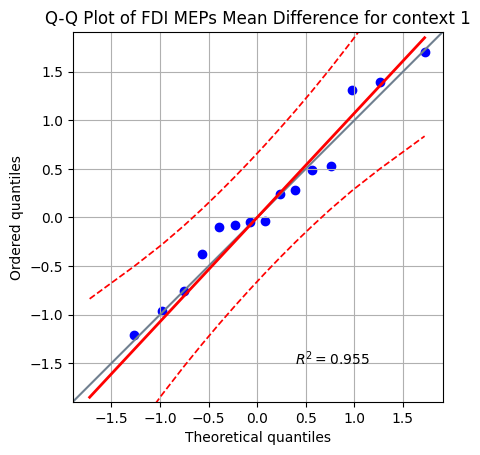

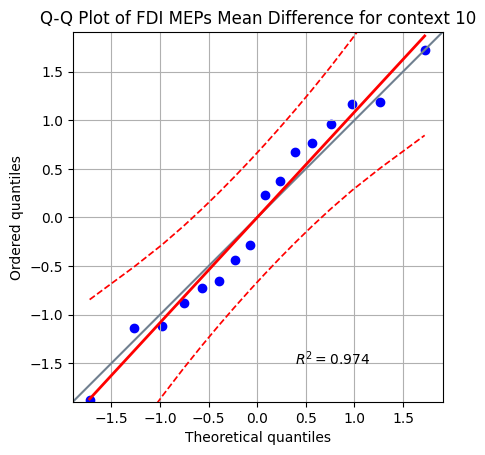

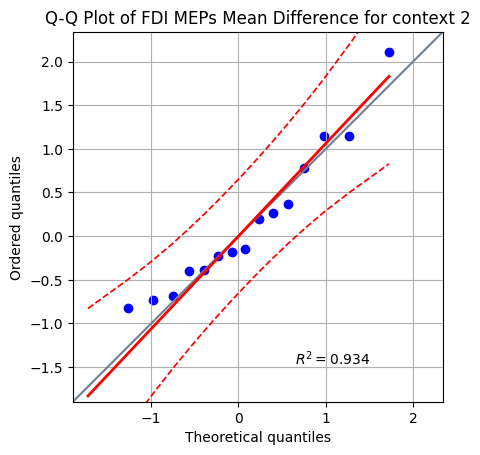

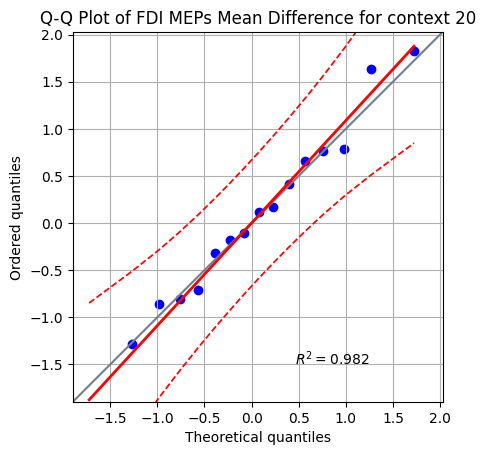

In [40]:
# Get Mean FDI MEPs by Contexts and Previous Result and Plot    
mean_FDImeps_ctx_prevresult = meps_blocks_df.groupby(['ID_info', 'context', 'last_was_error'])['relMean_MEPpp_FDI'].mean().reset_index()

# Create a pivot table to calculate mean relMean_MEPpp_FDI for each combination
pivot_table = pd.pivot_table(mean_FDImeps_ctx_prevresult,
                            values='relMean_MEPpp_FDI',
                            index=['ID_info', 'context'],
                            columns='last_was_error',
                            aggfunc='mean',
                            fill_value=0)

# Calculate the difference between last_was_error categories
pivot_table['mean_difference'] = pivot_table[1] - pivot_table[0]

# Back to stack structure
stacked_df = pivot_table[['mean_difference']].reset_index()
stacked_df['reference'] = 0

# Perform Shapiro-Wilk test for normality
shapiro_results = pg.normality(stacked_df, dv='mean_difference', group='context')
print(shapiro_results)
print("\n")

# Perform Homocedasticity test
levene_results = pg.homoscedasticity(stacked_df, dv='mean_difference', group='context')
print(levene_results)

# Q-Q plots for each response category
ctx_categories = stacked_df['context'].unique()
for i in ctx_categories:
    plt.figure()  # Create a new figure for each response category
    pg.qqplot(stacked_df[stacked_df['context'] == i]['mean_difference'], dist='norm')
    plt.title(f'Q-Q Plot of FDI MEPs Mean Difference for context {i}')
    plt.grid(True)
    plt.show()

# # Histograms for each response category
# for i in ctx_categories:
#     plt.figure()  # Create a new figure for each response category
#     sns.histplot(stacked_df[stacked_df['context'] == i]['mean_difference'], kde=True)
#     plt.title(f'Histogram of FDI MEPs Mean Difference for context {i}')
#     plt.xlabel('FDI MEPs Mean Difference')
#     plt.ylabel('Frequency')
#     plt.show()

In [41]:
### Using Paired T test and Benjamini/Hochberg correction

# Assuming stacked_df is your DataFrame
results_list = []

for context in stacked_df['context'].unique():
    context_data = stacked_df[stacked_df['context'] == context]
    
    # Perform paired t-test using pingouin
    results = pg.ttest(context_data['mean_difference'], context_data['reference'], paired=True)
    
    # Append all relevant metrics to the list
    results_list.append({
        'context': context,
        'statistic': results['T'].iloc[0],
        'p-val': results['p-val'].iloc[0],
        'cohen-d': results['cohen-d'].iloc[0] # Effect size
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Apply Benjamini/Hochberg correction using pingouin.multicomp
reject, pvals_corrected = pg.multicomp(results_df['p-val'], method='fdr_bh')

# Add adjusted p-values to the results DataFrame
results_df['adjusted_p-val'] = pvals_corrected
results_df['reject'] = reject

results_df

,context,statistic,p-val,cohen-d,adjusted_p-val,reject
0,00,0.044625,0.964995,0.015777,0.964995,False
1,1,1.600007,0.130443,0.565688,0.505204,False
2,10,1.034444,0.317319,0.365731,0.528865,False
3,2,0.376621,0.711729,0.133156,0.889662,False
4,20,-1.334074,0.202081,0.471666,0.505204,False
